In [212]:
import numpy as np
import pandas as pd
from cmdstanpy import cmdstan_path, CmdStanModel
from sklearn.metrics import r2_score
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
import arviz
import statsmodels.api as sm
import tqdm

from datamodel import SPX, StockData
from model_testing import BayesModel, BayesTimeSeriesCrossVal, create_lags

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)

In [76]:
spx = SPX()
vix_data = StockData(["^VIX"])

spx_wk_prices = spx.prices.resample("W-FRI").last()
spx_wk_returns = (np.log(spx_wk_prices) - np.log(spx_wk_prices.shift(1))).dropna()
spx_wk_vol = np.sqrt(spx.vol.resample("W-FRI").sum())

In [209]:
spx_vol_lags = create_lags(np.log(np.sqrt(spx.vol)), 21, "spx_vol")
vix_lags = create_lags(np.log(vix_data.prices.VIX["close"]), 21, "vix")
spx_return_lags = create_lags(spx.returns, 21, "spx_returns")

x = pd.concat([spx_vol_lags, vix_lags, spx_return_lags], axis=1).dropna()
y = np.log(spx_wk_vol.shift(-1).dropna())

common_index = x.index.intersection(y.index)

x = x.loc[common_index]
y = y.loc[common_index]

In [80]:
model_spec = """
    data {
        int N;  // Number of observations
        int p;  // Number of variables
        vector[N] y;
        matrix[N, p] X;
    }
    parameters {
        real mu;
        real<lower=0> rho;
        vector[p] beta;
        real<lower=0> sigma;
    }
    model {
        mu ~ normal(0, 10);
        rho ~ normal(0, 1);
        beta ~ normal(0, rho);
        sigma ~ normal(0, 10);

        y ~ normal(mu + (X * beta), sigma);
    }
    generated quantities {
        real y_tilde[N] = normal_rng(mu + (X * beta), sigma);
    }
    """
with open("./stan_model/model.stan", "w") as file:
    file.write(model_spec)

model = CmdStanModel(stan_file="./stan_model/model.stan")

INFO:cmdstanpy:compiling stan program, exe file: /home/eadains/VolatilityTrading/stan_model/model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/eadains/VolatilityTrading/stan_model/model


In [247]:
model_spec = """
    data {
        int N;  // Number of observations
        int p;  // Number of variables
        vector[N] y;
        matrix[N, p] X;
    }
    parameters {
        real mu;
        real<lower=0> rho;
        vector[p] beta;
        real theta;
        real<lower=0> sigma;
    }
    transformed parameters {
        real epsilon[N];
        real nu[N];
        
        epsilon[1] = y[1] - (mu + X[1] * beta);
        for (t in 2:N) {
            epsilon[t] = y[t] - (mu + (X[t] * beta) + theta * epsilon[t-1]);
        }
        
        nu[1] = mu + X[1] * beta;
        for (t in 2:N) {
            nu[t] = mu + X[t] * beta + theta * epsilon[t-1];
        }
    }
    model {
        mu ~ normal(0, 10);
        rho ~ normal(0, 1);
        beta ~ normal(0, rho);
        theta ~ normal(0, 2);
        sigma ~ normal(0, 10);
        
        y ~ normal(nu, sigma);
    }
    generated quantities {
        real y_tilde[N];
        y_tilde = normal_rng(5, nu, sigma);
    }
    """
with open("./stan_model/model.stan", "w") as file:
    file.write(model_spec)

model = CmdStanModel(stan_file="./stan_model/model.stan")

In [248]:
data = {"N": len(x),
        "p": len(x.columns),
        "y": y.values,
        "X": x.values}
sample = model.sample(data=data, iter_warmup=1000, iter_sampling=2500, max_treedepth=15, show_progress=True)

Chain 2 - warmup:   0%|                                                                                                                                                       | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|                                                                                                                                                    | 0/3500 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|                                                                                                                                                       | 0/1 [00:00<?, ?it/s]


Chain 4 - warmup:   0%|                                                                                                                                                       | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|                                                                                                                                                    | 0/3500 [00:00<?, ?it/s]


Chain 4 

Chain 2 - sample:  29%|███████████████████████████████████████▏                                                                                                 | 1000/3500 [04:48<08:11,  5.09it/s]


Chain 4 - warmup:  26%|███████████████████████████████████▍                                                                                                      | 900/3500 [04:56<08:41,  4.99it/s]

Chain 2 - sample:  31%|███████████████████████████████████████████                                                                                              | 1100/3500 [05:09<08:01,  4.98it/s]


Chain 4 - warmup:  29%|███████████████████████████████████████▏                                                                                                 | 1000/3500 [05:15<08:14,  5.05it/s]


Chain 4 - sample:  29%|███████████████████████████████████████▏                                                                                                 | 1000/3500 [05:15<08:14,  5.05it/s]


Chain 

Chain 2 - sample:  63%|██████████████████████████████████████████████████████████████████████████████████████                                                   | 2200/3500 [09:08<04:43,  4.58it/s]


Chain 1 - sample:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2500/3500 [09:14<03:23,  4.90it/s]

Chain 2 - sample:  66%|██████████████████████████████████████████████████████████████████████████████████████████                                               | 2300/3500 [09:29<04:19,  4.62it/s]


Chain 1 - sample:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2600/3500 [09:35<03:03,  4.91it/s]

Chain 2 - sample:  69%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2400/3500 [09:51<03:57,  4.63it/s]


Chain 1

Chain 4 -   done: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3500/3500 [13:40<00:00,  4.26it/s]


In [249]:
sample.diagnose()

INFO:cmdstanpy:Processing csv files: /tmp/tmpoxgqz9yt/model-202107301849-1-4z70ec28.csv, /tmp/tmpoxgqz9yt/model-202107301849-2-0kynef7h.csv, /tmp/tmpoxgqz9yt/model-202107301849-3-_lnonxsa.csv, /tmp/tmpoxgqz9yt/model-202107301849-4-50p12fd_.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


'Processing csv files: /tmp/tmpoxgqz9yt/model-202107301849-1-4z70ec28.csv, /tmp/tmpoxgqz9yt/model-202107301849-2-0kynef7h.csv, /tmp/tmpoxgqz9yt/model-202107301849-3-_lnonxsa.csv, /tmp/tmpoxgqz9yt/model-202107301849-4-50p12fd_.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'

In [250]:
arviz_data = arviz.from_cmdstanpy(
    posterior=sample,
    posterior_predictive="y_tilde",
    observed_data={"y": y.values}
)

In [251]:
y_tilde = arviz_data.posterior_predictive.y_tilde.values.reshape(10000, -1)
residuals = y.values - np.mean(y_tilde, axis=0)
mean = np.mean(y_tilde, axis=1)
std = np.std(y_tilde, axis=1)
skew = stats.skew(y_tilde, axis=1)
kurt = stats.kurtosis(y_tilde, axis=1)

Text(0.5, 1.0, 'Kurtosis')

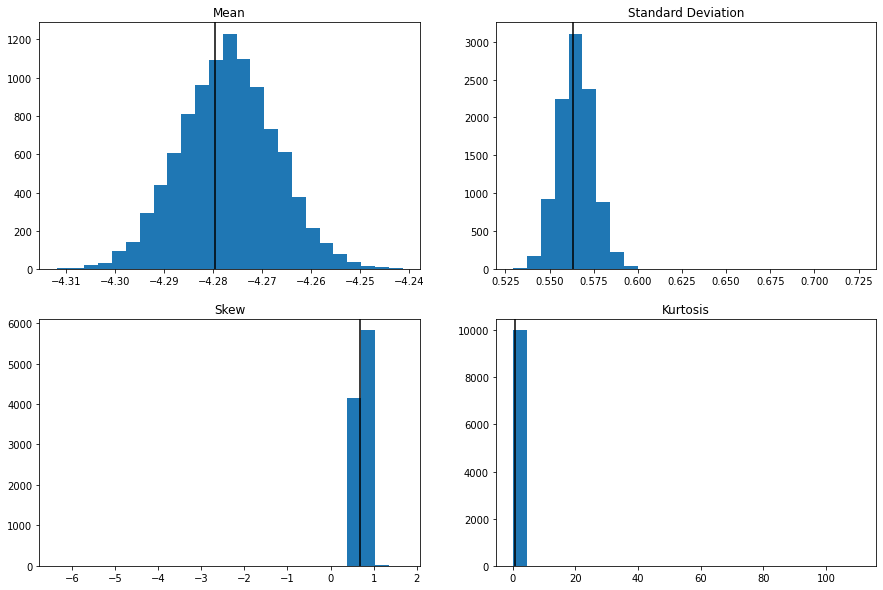

In [252]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(mean, bins=25)
axs[0, 0].axvline(np.mean(y), color='black')
axs[0, 0].set_title("Mean")
axs[0, 1].hist(std, bins=25)
axs[0, 1].axvline(np.std(y), color='black')
axs[0, 1].set_title("Standard Deviation")
axs[1, 0].hist(skew, bins=25)
axs[1, 0].axvline(stats.skew(y), color='black')
axs[1, 0].set_title("Skew")
axs[1, 1].hist(kurt, bins=25)
axs[1, 1].axvline(stats.kurtosis(y), color='black')
axs[1, 1].set_title("Kurtosis")

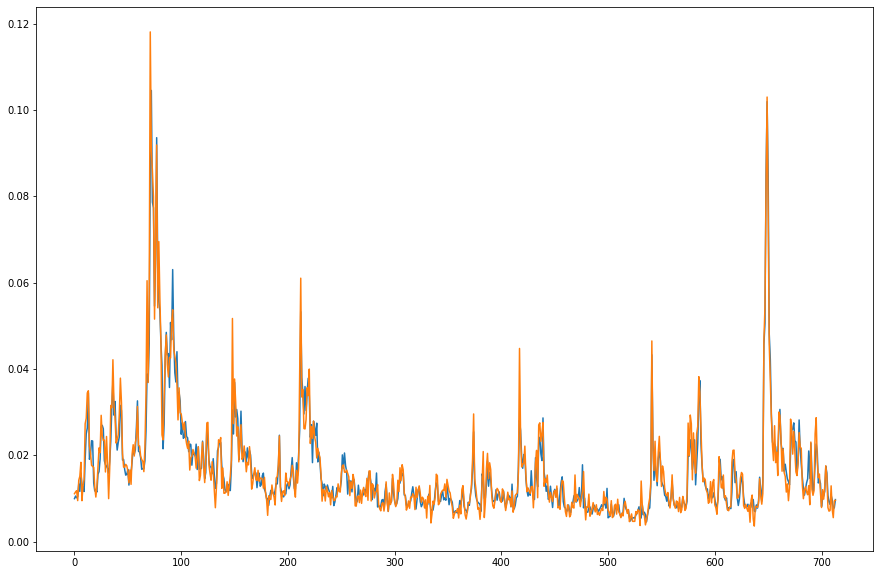

In [253]:
plt.plot(np.exp(np.mean(y_tilde, axis=0)))
plt.plot(np.exp(y.values))

<AxesSubplot:xlabel='y / y_tilde'>

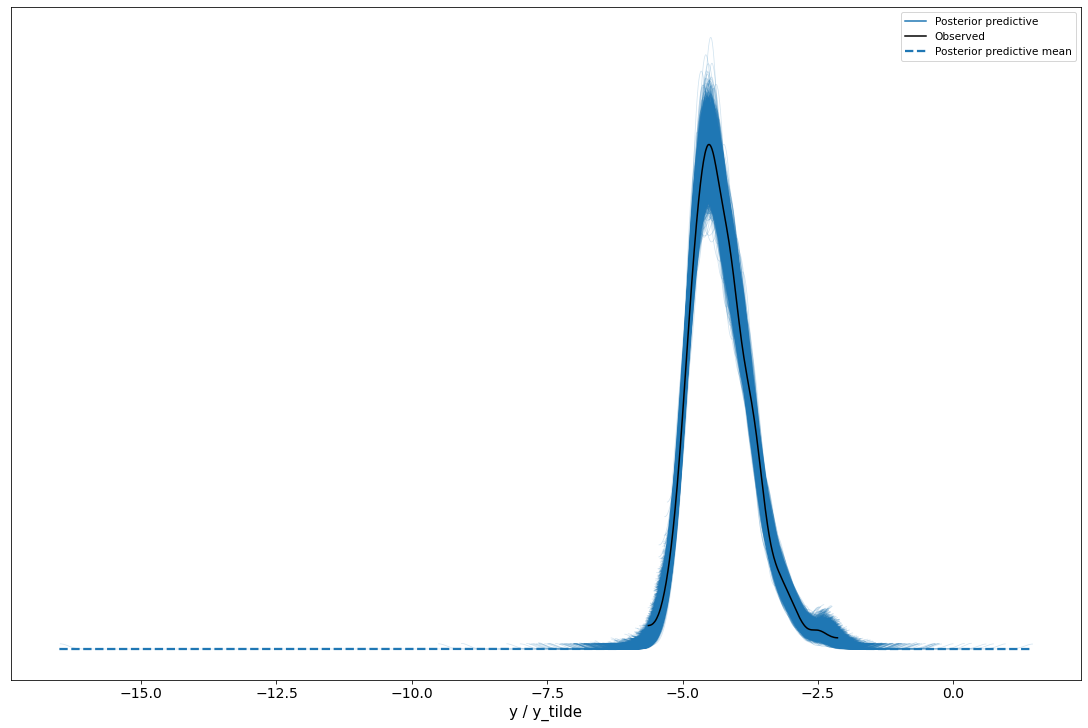

In [254]:
arviz.plot_ppc(arviz_data, data_pairs={"y": "y_tilde"})

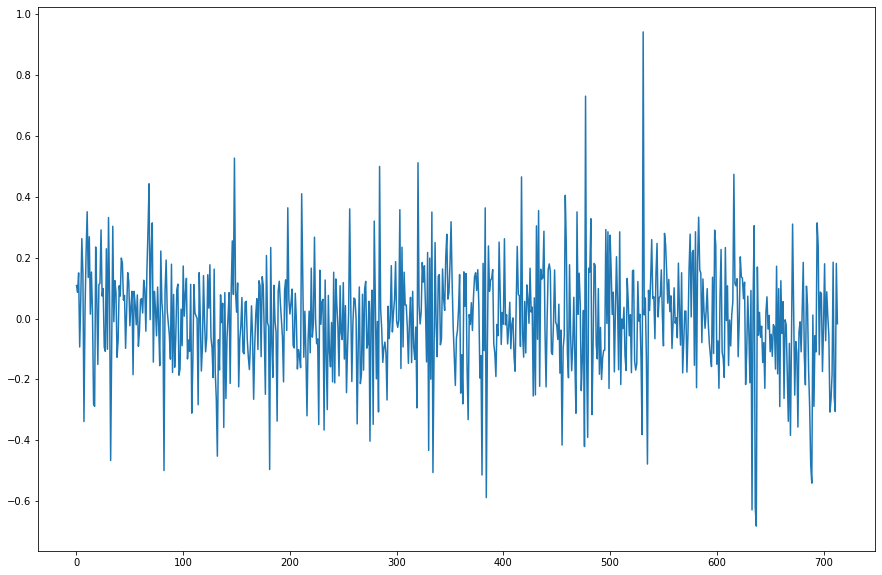

In [255]:
plt.plot(residuals)

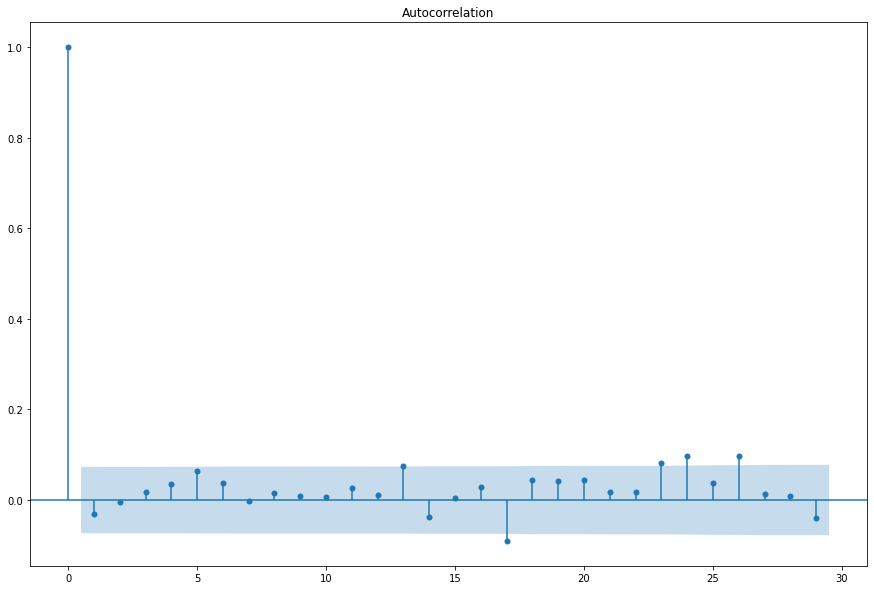

In [256]:
acf = sm.tsa.graphics.plot_acf(residuals)

/home/eadains/VolatilityTrading/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


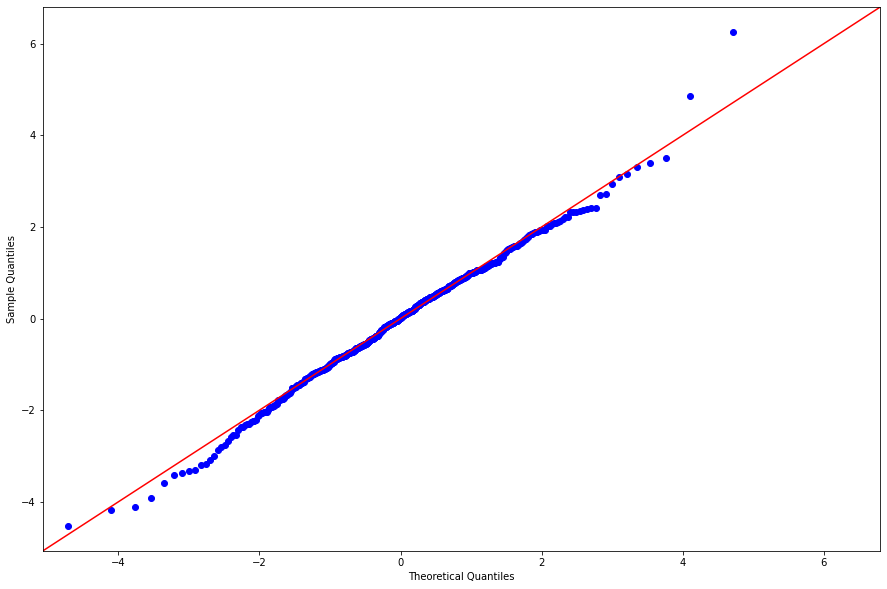

In [258]:
fig = sm.graphics.qqplot(residuals, stats.t, distargs=(5,), line="45", fit=True)

In [118]:
model = RegularizedLinearBayes()
model_test = BayesTimeSeriesCrossVal(x, y, model, splits=25, min_samples=104)
results = model_test.walk_forward_test()

INFO:cmdstanpy:compiling stan program, exe file: /home/eadains/VolatilityTrading/stan_model/model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/eadains/VolatilityTrading/stan_model/model
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 0 complete.


INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 1 complete.


INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 2 complete.


INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 3 complete.


INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 4 complete.


INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 5 complete.


INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 6 complete.


INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 7 complete.


INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 8 complete.


INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 9 complete.


INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 10 complete.


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 11 complete.


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 12 complete.


INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 13 complete.


INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 14 complete.


INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 15 complete.


INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 16 complete.


INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 17 complete.


INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 18 complete.


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 19 complete.


INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 20 complete.


INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 21 complete.


INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


Split 22 complete.


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


Split 23 complete.


In [119]:
y_tilde = [n["y_tilde"] for n in results]
y_pred = pd.concat([n["mean"] for n in results])
residuals = pd.concat([n["residuals"] for n in results])
r2 = [n["r2"] for n in results]
coverage_95 = [n["95_coverage"] for n in results]
coverage_5 = [n["5_coverage"] for n in results]
uniformity = [n["uniformity"].pvalue for n in results]

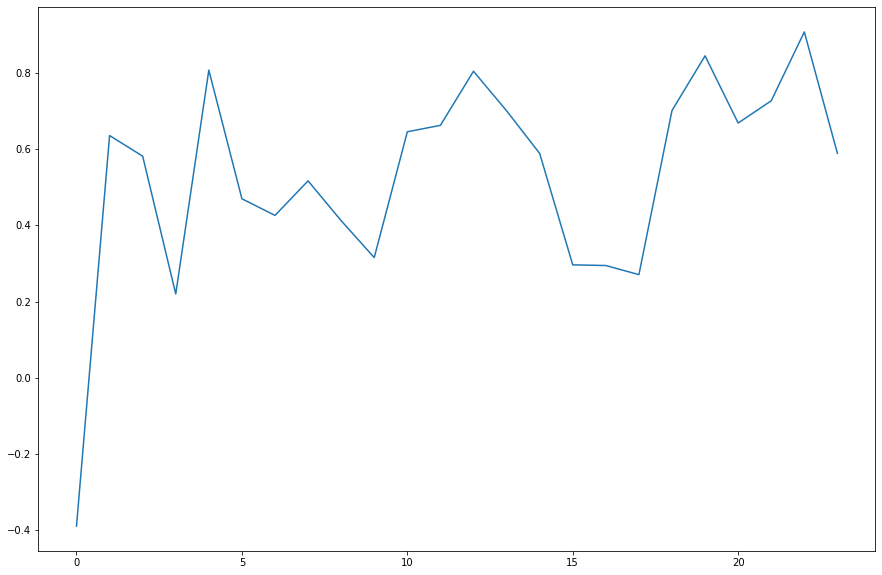

In [120]:
plt.plot(r2)

<AxesSubplot:>

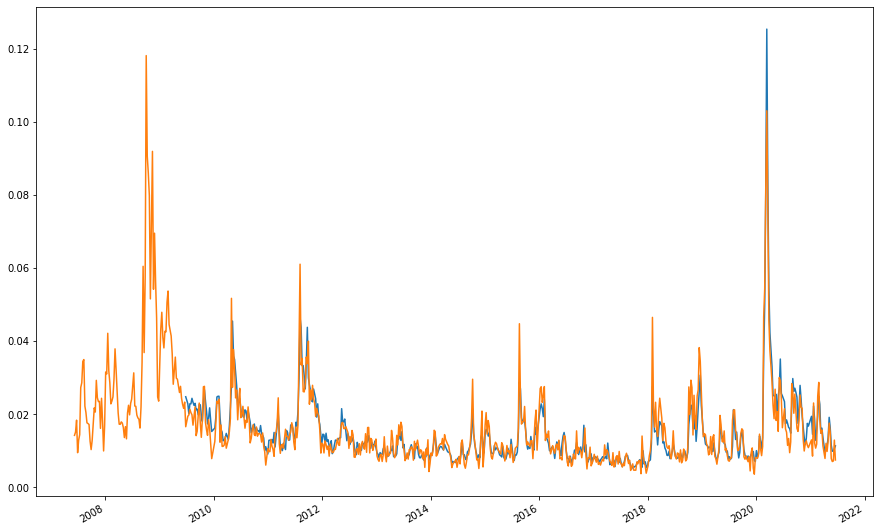

In [121]:
np.exp(y_pred).plot()
np.exp(y).plot()

<AxesSubplot:>

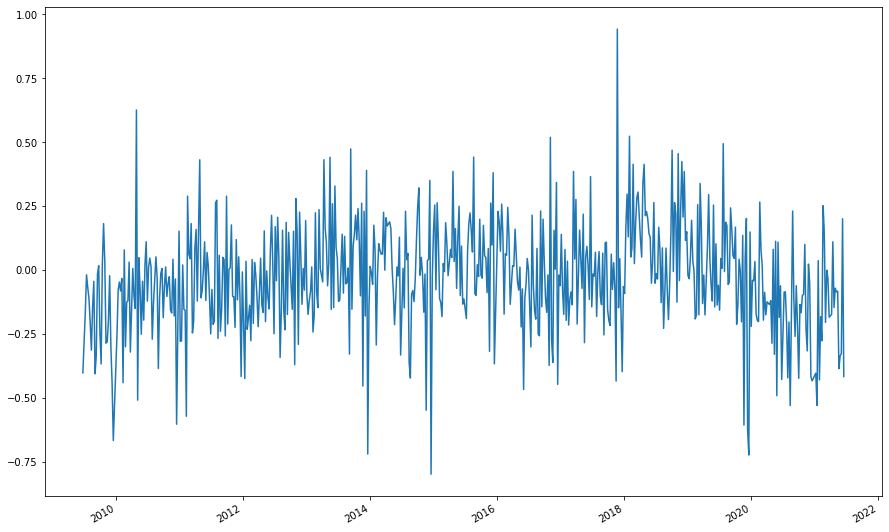

In [122]:
residuals.plot()

(array([  4.,  11.,  50., 153., 209., 125.,  38.,  11.,   1.,   1.]),
 array([-0.7990815 , -0.62489513, -0.45070875, -0.27652238, -0.102336  ,
         0.07185037,  0.24603674,  0.42022312,  0.59440949,  0.76859587,
         0.94278224]),
 <BarContainer object of 10 artists>)

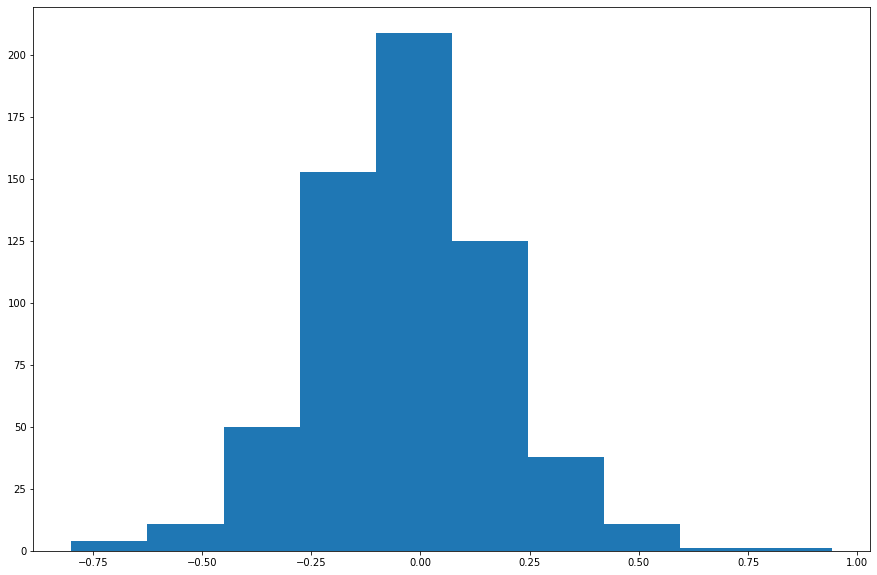

In [123]:
plt.hist(residuals)

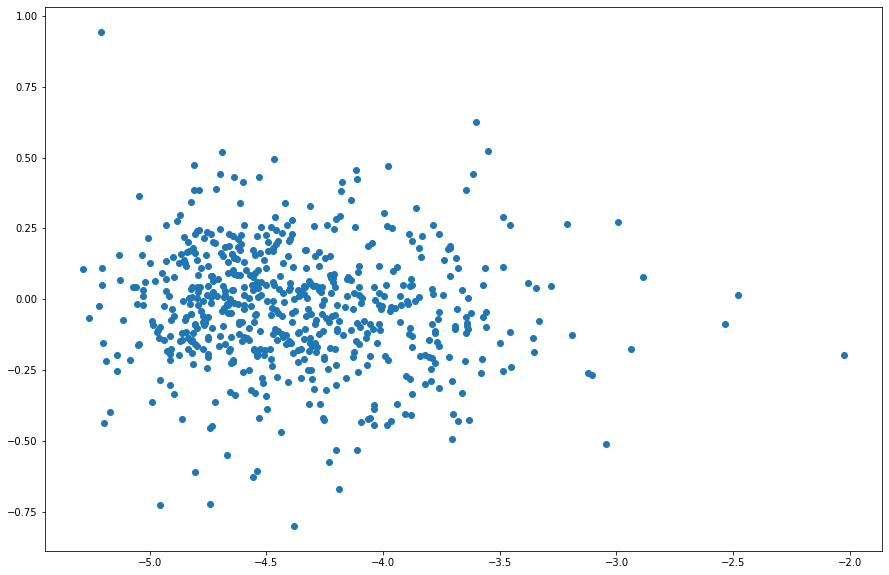

In [146]:
plt.scatter(x=predicted, y=residuals)

/home/eadains/VolatilityTrading/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


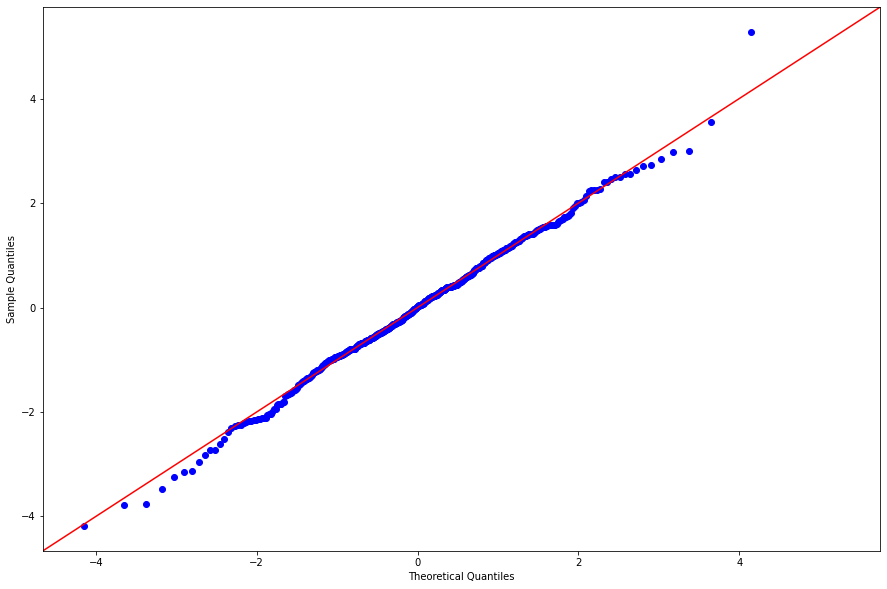

In [154]:
fig = sm.graphics.qqplot(residuals, stats.t, distargs=(2,), line="45", fit=True)